In [1]:
import networkx as nx
import json
import nltk
import matplotlib.pyplot as plt

from wordExplorer.utils import getWordData, loadWord2Vec, jsonSimi

In [2]:
def getCalculator(mName: str = None):
    if mName is not None:
        model = loadWord2Vec(mName)
    else:
        model = loadWord2Vec()

    def calcGraph(word: str, loc: str = './data/', apiKwargs: dict = None, word2vecKwargs: dict = None) -> nx.Graph:
        if apiKwargs is None:
            apiKwargs = {}

        if word2vecKwargs is None:
            word2vecKwargs = {}

        #Getting the raw graph structure
        try:
            with open(loc + f'synonyms/{word}.json', "r", encoding="utf-8") as f:
                data = json.load(f)
        except FileNotFoundError:
            data = getWordData(word, loc + 'synonyms/', **apiKwargs)
            with open(loc + f'synonyms/{word}.json', "w", encoding="utf-8") as f:
                json.dump(data, f)

        G = nx.Graph(data)
        
        #Getting the weights for the graph
        try:
            with open(loc + f'weights/{word}.json', "r", encoding="utf-8") as f:
                weights = jsonSimi(json.load(f))
        except FileNotFoundError:
            weights = model(data, **word2vecKwargs)
            with open(loc + f'weights/{word}.json', "w", encoding="utf-8") as f:
                json.dump(jsonSimi(weights), f)

        nx.set_edge_attributes(G, weights, 'weight')
        return G
    
    return calcGraph

def posTag(char: str) -> str:
    punc = ".,!?;“”"
    def puncSwap(char: str, pos: str):
        if char in punc:
            return 'PUN'
        else:
            return pos

    return list(map(lambda x: (x[0], puncSwap(x[0], x[1])), \
        nltk.pos_tag(nltk.word_tokenize(char))))

def lemmatize(char: str) -> str:
        lmn = nltk.stem.WordNetLemmatizer()

        wordnetConv = {
            'J': 'a',
            'V': 'v',
            'N': 'n',
            'R': 'r'
        }

        return map(lambda x: lmn.lemmatize(x[0], wordnetConv.get(x[1][0], 'n')), posTag(char))

In [3]:
calc = getCalculator()

In [ ]:
obama = [
    # 'entangled',
    # 'request',
    # 'surge',
    # 'migrants',
    # 'flood',
    # 'children',
    # 'beefing',
    # 'presence',
    # 'tougher',
    # 'enforcement',
    # 'strong',
    # 'misgivings',
    # 'charged',
    # 'shadow',
    # 'politics',
    # 'emphasize',
    # 'trip',
    # 'relax',
    # 'deportations',
    # 'round',
    # 'discussion',
    # 'sweeping',
    # 'actions',
    # 'path',
    # 'bill',
    # 'flexibility',
    # 'treat',
    # 'combating',
    # 'trafficking',
    # 'aggressive',
    # 'plan',
    # 'cut',
    # 'process'
]

In [ ]:
for word in obama:
    calc(list(lemmatize(word))[0])
    # print(list(lemmatize(word))[0])

In [4]:
# g = nx.from_dict_of_dicts(net)
g = calc('surge', apiKwargs={'order': 2})
h = calc('flood', apiKwargs={'order': 2})

g = nx.compose(g, h)
# g = nx.intersection(g, h)

Eval: surge-cast-2
Eval: surge-exhale-2
Eval: surge-expand-2
Eval: surge-heave-2
Eval: surge-erupt-2
Eval: surge-spread-2
Eval: surge-crescendo-2
Eval: surge-accelerate-2
Eval: surge-jump-2
Eval: surge-jet-2
Eval: surge-issue-2
Eval: surge-disgorge-2
Eval: surge-expel-2
Eval: surge-toss-2
Eval: surge-spit-2
Eval: surge-boom-2
Eval: surge-distend-2
Eval: surge-rocket-2
Eval: surge-proliferate-2
Eval: surge-billow-2
Eval: surge-fling-2
Eval: surge-build up-2
Eval: surge-accumulate-2
Eval: surge-snowball-2
Eval: surge-wave-2
Eval: surge-emanate-2
Eval: surge-increase-2
Eval: surge-multiply-2
Eval: surge-stream-2
Eval: surge-wax-2
Eval: surge-spew-2
Eval: surge-blow up-2
Eval: surge-burgeon-2
Eval: surge-fire-2
Eval: surge-shoot-2
Eval: surge-pitch-2
Eval: surge-peak-2
Eval: surge-appreciate-2
Eval: surge-bulk-2
Eval: surge-spring-2
Eval: surge-gain-2
Eval: surge-mushroom-2
Eval: surge-spurt-2
Eval: surge-belch-2
Eval: surge-skyrocket-2
Eval: surge-launch-2
Eval: surge-balloon-2
Eval: surg

In [5]:
print(g)

Graph with 3072 nodes and 5737 edges


In [6]:
# edges = nx.get_edge_attributes(g, "weight")
edges = [g.get_edge_data(u, v).get("weight", 1.0) ** 4 / 12 for u, v in g.edges()]

colDict = { idx+1: val for idx, val in enumerate([
    '#ff0000',
    '#ff4500',
    '#ff8900',
    '#ffce00',
    '#ebff00',
    '#a6ff00',
    '#62ff00',
    '#1dff00',
    '#00ff28',
    '#00ff6d',
    '#00ffb1',
    '#00fff6',
])}

colDict[0] = "#ff00ff"

depth = nx.shortest_path_length(g, "flood")

nodeCols = [colDict.get(depth.get(key, -1), "#00ffff") for key, val in g.nodes().items()]

In [7]:
pos = nx.kamada_kawai_layout(g)
# pos = nx.circular_layout(g)

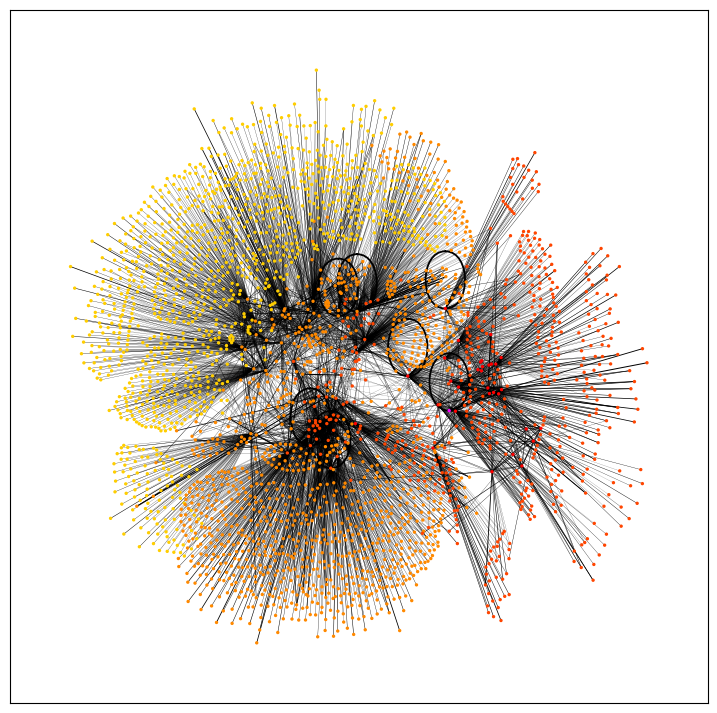

In [8]:
plt.figure(1, figsize=(9, 9))
# nx.draw(g, pos=pos)
nx.draw_networkx_edges(g, pos, width=edges)
nx.draw_networkx_nodes(g, pos, node_color=nodeCols, node_size=2)
# nx.draw_networkx_labels(g, pos)

In [11]:
# nx.centrality.eigenvector_centrality(g, max_iter=10**4, weight='weight')
nx.centrality.harmonic_centrality(g, distance='weight')
# nx.centrality.closeness_centrality(g, distance='weight')

{'lots': 678.5056759228689,
 'abundances': 704.6151619372102,
 'compose': 796.7516325135434,
 'torpedo bombers': 839.9848468015218,
 'redundancies': 854.9484152533576,
 'creates': 806.165341543399,
 'demur': 742.3786531455974,
 'encourage': 828.6701852638538,
 'wain': 725.4922970459921,
 'effuse': 647.0572345697263,
 'crane': 819.973847491794,
 'assemble': 815.835855422431,
 'found': 755.6651782522326,
 'execution': 767.3286005477056,
 'total': 828.7184285946598,
 'apocalypse': 608.1835891752365,
 'creek': 616.0779436052119,
 'look-alike': 737.604790239149,
 'groovy': 793.2802258424205,
 'radiance': 721.5836872815931,
 'pierce': 701.7512930452704,
 'castigate': 816.015522143255,
 'ascend': 782.7364921422674,
 'plenty': 690.9694891983384,
 'notion': 709.818068820553,
 'plutocracy': 755.688605660797,
 'intellection': 731.6331918966582,
 'bring down': 834.7699668998063,
 'superabundance': 705.1219896233978,
 'protuberance': 787.8870085595478,
 'lay': 789.2297712278948,
 'hangdog': 805.014